<a href="https://colab.research.google.com/github/AlexandreBrown/AerialSemanticSegmentation/blob/main/SemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation

In [30]:
!pip3 install torch==1.10.0 matplotlib

  Using cached torch-1.10.0-cp39-cp39-manylinux1_x86_64.whl (881.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0
    Uninstalling torch-1.9.0:
      Successfully uninstalled torch-1.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0 requires torch==1.9.0, but you have torch 1.10.0 which is incompatible.
mdai-core 0.1 requires numpy>=1.21.0, but you have numpy 1.20.3 which is incompatible.


In [ ]:
!conda install -y -c conda-forge albumentations

In [ ]:
!conda install -y -c conda-forge imgaug

In [ ]:
!conda install -y -c conda-forge segmentation-models-pytorch

# Notebook Dependencies

In [4]:
import matplotlib.pylab as plt

%matplotlib inline

# Setup Configurations

In [5]:
IMAGES_BASE_PATH = "../semantic-drone-dataset/images/"
MASKS_BASE_PATH = "../semantic-drone-dataset/masks/"

DEVICE = "cuda"

EPOCHS = 25
LR = 0.01
TARGET_IMAGE_HEIGHT = 512
TARGET_IMAGE_WIDTH = 768
BATCH_SIZE = 8

# Dataset Definition

In [6]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset
from os import listdir
from os.path import isfile, join
from PIL import Image
from PIL import ImageOps

class SemanticSegmentationOnDiskDataset(Dataset):
    
    def __init__(self, images_base_path = None, masks_base_path = None, images_paths = None, masks_paths = None, transforms=None):
        self.validate_constructor_inputs(images_base_path, masks_base_path, images_paths, masks_paths)
        
        self.transforms = transforms
        
        if images_base_path and masks_base_path:
            self.images_paths = self.get_files_paths(images_base_path)
            self.images_paths.sort()
            

            self.masks_paths = self.get_files_paths(masks_base_path)
            self.masks_paths.sort()
            
        else:
            self.images_paths = images_paths
            self.masks_paths = masks_paths
            
        print(f"{len(self.images_paths)} images paths loaded")
        print(f"{len(self.masks_paths)} masks paths loaded")
        
    def validate_constructor_inputs(self,images_base_path, masks_base_path, images_paths, masks_paths):
        assert ((images_base_path is not None and masks_base_path is not None) or
                (images_paths is not None and masks_paths is not None)), "You must provide one of the two : \n(1) The images base path and masks base path\n(2) The images paths and masks paths"
        
    def get_files_paths(self, base_bath):
        return [join(base_bath, file_name) for file_name in listdir(base_bath) if isfile(join(base_bath, file_name))]

    def __len__(self):
        return len(self.images_paths)
    
    def get_x(self):
        return self.images_paths
    
    def get_y(self):
        return self.masks_paths
    
    def get_xy(self):
        return pd.DataFrame({'X':self.get_x(),'Y':self.get_y()})

    def __getitem__(self, index):

        image = self.get_image(index)
        mask = self.get_mask(index)

        if self.transforms:
            transformed_data = self.transforms(image = image, mask = mask)
            image = transformed_data["image"]
            mask = transformed_data["mask"]
            mask = mask.permute(2,0,1)
            return image, mask
        
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.Tensor(image)
        
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
        mask = torch.round(torch.Tensor(mask))

        return image, mask
    
    def get_image(self, index):
        image_path = self.images_paths[index]
        image = Image.open(image_path)
        image = np.array(image)
        return image
    
    def get_mask(self, index):
        mask_path = self.masks_paths[index]
        mask = Image.open(mask_path)
        mask = ImageOps.grayscale(mask)
        mask = np.array(mask)
        mask = np.expand_dims(mask, axis= -1)
        return mask

# Dataset Visualization

In [7]:
import gc

def show_image_mask(image, mask):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    displayable_image = image.permute(1, 2, 0).detach().numpy()
    ax1.set_title('IMAGE')
    ax1.imshow(displayable_image)

    displayable_mask = mask.permute(1, 2, 0).detach().numpy()
    ax2.set_title('GROUND TRUTH')
    ax2.imshow(displayable_mask, cmap = 'gray')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    gc.collect()

In [8]:
visualization_dataset = SemanticSegmentationOnDiskDataset(images_base_path=IMAGES_BASE_PATH, masks_base_path=MASKS_BASE_PATH)

400 images paths loaded
400 masks paths loaded


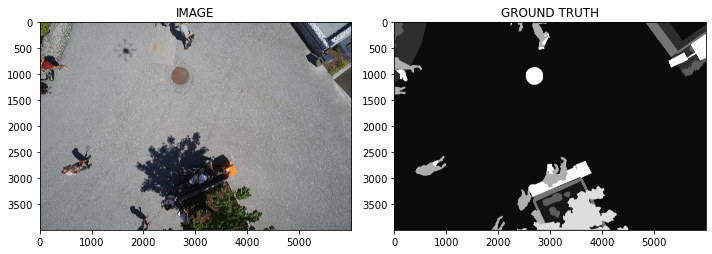

In [9]:
index = 0

image, mask = visualization_dataset[index]

show_image_mask(image / 255.0, mask)

# Transforms Definition

In [10]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_training_transforms(
    target_image_height, 
    target_image_width,
    horizontal_flip_probability=0.5,
    vertical_flip_probability=0.5,
):
    image_net_mean = [0.485, 0.456, 0.406]
    image_net_std = [0.229, 0.224, 0.225]
    
    return A.Compose([
        A.Resize(target_image_height, target_image_width),
        A.HorizontalFlip(p=horizontal_flip_probability),
        A.VerticalFlip(p=vertical_flip_probability),
        A.Normalize(mean=image_net_mean, std=image_net_std),
        ToTensorV2()
    ])

def get_validation_transforms(
    target_image_height, 
    target_image_width,
):
    image_net_mean = [0.485, 0.456, 0.406]
    image_net_std = [0.229, 0.224, 0.225]
    
    return A.Compose([
        A.Resize(target_image_height, target_image_width),
        A.Normalize(mean=image_net_mean, std=image_net_std),
        ToTensorV2()
    ])

# Split Datasets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
visualization_dataset.get_xy()

,X,Y
0,../semantic-drone-dataset/images/1.jpg,../semantic-drone-dataset/masks/1.png
1,../semantic-drone-dataset/images/10.jpg,../semantic-drone-dataset/masks/10.png
2,../semantic-drone-dataset/images/100.jpg,../semantic-drone-dataset/masks/100.png
3,../semantic-drone-dataset/images/101.jpg,../semantic-drone-dataset/masks/101.png
4,../semantic-drone-dataset/images/102.jpg,../semantic-drone-dataset/masks/102.png
...,...,...
395,../semantic-drone-dataset/images/95.jpg,../semantic-drone-dataset/masks/95.png
396,../semantic-drone-dataset/images/96.jpg,../semantic-drone-dataset/masks/96.png
397,../semantic-drone-dataset/images/97.jpg,../semantic-drone-dataset/masks/97.png
398,../semantic-drone-dataset/images/98.jpg,../semantic-drone-dataset/masks/98.png


In [13]:
training_df, validation_df = train_test_split(visualization_dataset.get_xy(), test_size=0.2)

In [14]:
training_df.shape

(320, 2)

In [15]:
validation_df.shape

(80, 2)

# Preprocess Datasets

In [16]:
training_dataset = SemanticSegmentationOnDiskDataset(
    images_paths=training_df.X.to_numpy(), 
    masks_paths=training_df.Y.to_numpy(), 
    transforms=get_training_transforms(
        target_image_height=TARGET_IMAGE_HEIGHT,
        target_image_width=TARGET_IMAGE_WIDTH
    )
)

320 images paths loaded
320 masks paths loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


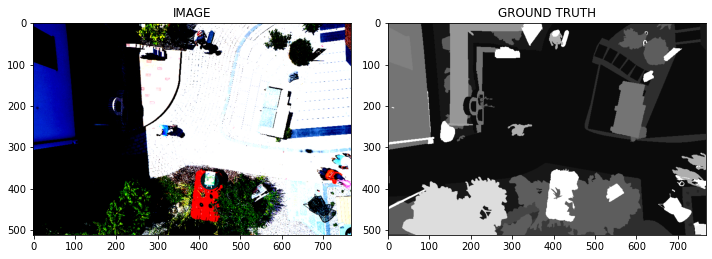

In [17]:
image, mask = training_dataset[0]

show_image_mask(image, mask)

In [18]:
validation_dataset = SemanticSegmentationOnDiskDataset(
    images_paths=validation_df.X.to_numpy(), 
    masks_paths=validation_df.Y.to_numpy(), 
    transforms=get_validation_transforms(
        target_image_height=TARGET_IMAGE_HEIGHT,
        target_image_width=TARGET_IMAGE_WIDTH
    )
)

80 images paths loaded
80 masks paths loaded


# Load dataset into batches

In [19]:
from torch.utils.data import DataLoader

In [20]:
training_loader = DataLoader(dataset=training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total no. of batches in training loader {len(training_loader)}")
print(f"Total no. of batches in validation loader {len(validation_loader)}")

Total no. of batches in training loader 40
Total no. of batches in validation loader 10


In [21]:
for images_batch, masks_batch in training_loader:  
    print(f"Images batch shape : {images_batch.shape}")
    print(f"Masks batch shape : {masks_batch.shape}")
    break

Images batch shape : torch.Size([8, 3, 512, 768])
Masks batch shape : torch.Size([8, 1, 512, 768])


# Model Definition

In [22]:
import torch.nn as nn

In [23]:
class DefaultUnetEncoder(nn.Module):
    
    def __init__(self):
        super(DefaultUnetEncoder, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv_1 = self.double_conv(3,64)
        self.double_conv_2 = self.double_conv(64,128)
        self.double_conv_3 = self.double_conv(128,256)
        self.double_conv_4 = self.double_conv(256,512)
        self.double_conv_5 = self.double_conv(512,1024)
        
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding='valid'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding='valid'),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, images):
        
        skip_connections = []
        
        images = self.double_conv_1(images)
        skip_connections.append(images)
        images = self.max_pool(images)
        
        images = self.double_conv_2(images)
        skip_connections.append(images)
        images = self.max_pool(images)
        
        images = self.double_conv_3(images)
        skip_connections.append(images)
        images = self.max_pool(images)
        
        images = self.double_conv_4(images)
        skip_connections.append(images)
        images = self.max_pool(images)
        
        images = self.double_conv_5(images)
        
        return images, reversed(skip_connections)
        

In [24]:
class DefaultUnetDecoder(nn.Module):
    
    def __init__(self):
        super(DefaultUnetDecoder, self).__init__()
        self.up_conv_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0)
        self.double_conv_1 = self.double_conv(1024,512)
        self.up_conv_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0)
        self.double_conv_2 = self.double_conv(512,256)
        self.up_conv_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.double_conv_3 = self.double_conv(256,128)
        self.up_conv_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.double_conv_4 = self.double_conv(128,64)
        
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding='valid'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding='valid'),
            nn.ReLU(inplace=True),
        )
    
    def set_skip_connections(self, skip_connections):
        self.skip_connections = skip_connections
    
    def forward(self, images):
        
        images = self.up_conv_1(images)
        images_cropped_down = self.crop_down(self.skip_connections[-1], images)
        images = torch.cat((images, images_cropped_down), dim=1)
        images = self.double_conv_1(images)
        
        images = self.up_conv_2(images)
        images_cropped_down = self.crop_down(self.skip_connections[-2], images)
        images = torch.cat((images, images_cropped_down), dim=1)
        images = self.double_conv_2(images)
        
        images = self.up_conv_3(images)
        images_cropped_down = self.crop_down(self.skip_connections[-3], images)
        images = torch.cat((images, images_cropped_down), dim=1)
        images = self.double_conv_3(images)
        
        images = self.up_conv_4(images)
        images_cropped_down = self.crop_down(self.skip_connections[-4], images)
        images = torch.cat((images, images_cropped_down), dim=1)
        images = self.double_conv_4(images)
        
        return images
    
    def crop_down(self, tensor, target_tensor):
        target_shape = target_tensor.shape[2]
        tensor_shape = tensor.shape[2]
        delta = tensor_shape - target_shape
        delta = delta // 2
        return tensor[:, :, delta:tensor_shape-delta, delta:tensor_shape-delta]

In [25]:
class UNet(nn.Module):
    
    def __init__(self, number_of_classes):
        super(UNet, self).__init__()
        
        self.encoder = DefaultUnetEncoder()
        self.decoder = DefaultUnetDecoder()
        
        self.output_conv = nn.Conv2d(in_channels=64, out_channels=number_of_classes, kernel_size=1, padding='valid')
        
        
    def forward(self, images):
        
        images, skip_connections = self.encoder(images)
        
        self.decoder.set_skip_connections(skip_connections)
        
        images = self.decoder(images)
        
        logits = self.output_conv(images)

        return logits

# Train Model

In [26]:
from tqdm import tqdm

def train(epochs, device, data_loader, model, optimizer, criterion):
  
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for images, masks in tqdm(data_loader):

            images = images.to(device)
            masks = masks.to(device)

            logits = model(images)
            loss = criterion(logits, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
        print(f"Epoch : {i+1} Train loss : {train_loss}")

    return total_loss / len(dataloader)

In [31]:
from segmentation_models_pytorch.losses import DiceLoss

model = UNet(number_of_classes=23).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = DiceLoss(mode='multiclass')

train(epochs=EPOCHS, device=DEVICE, data_loader=training_loader, model=model, optimizer=optimizer, criterion=criterion)

  0%|          | 0/40 [00:05<?, ?it/s]


TypeError: conv2d(): argument 'padding' (position 5) must be tuple of ints, not str